## Homework 2: Simple Spread Trading
## Pairs:  3. RYU XLU

In [77]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from datetime import datetime
import quandl
import functools
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import norm, pearsonr
from statsmodels.tsa.stattools import adfuller

## Data

### 1. Pulling data from Quandl

In [2]:
# Authenticate with Quandl API
quandl.ApiConfig.api_key = "XXXXXXXXXX"

etf_X = 'RYU'
etf_Y = 'XLU'

start_date = "2020-12-02"
end_date = "2022-11-15"


RYU = quandl.get_table('QUOTEMEDIA/PRICES', date = { 'gte': start_date, 'lte': end_date }, ticker=etf_X)
XLU = quandl.get_table('QUOTEMEDIA/PRICES', date = { 'gte': start_date, 'lte': end_date }, ticker=etf_Y)


### 2. Get the estimated daily dollar volume and the running median of it

In [3]:
RYU = RYU.sort_values('date')
RYU['date'] = pd.to_datetime(RYU['date'])
RYU.set_index('date', inplace=True)
RYU['daily_return'] = RYU['adj_close'].pct_change()
RYU['est_$volume'] = RYU['adj_close'] * RYU['adj_volume']
RYU['Nt'] = RYU['est_$volume'].rolling(window=15).median()
RYU

,ticker,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume,daily_return,est_$volume,Nt
date,,,,,,,,,,,,,,,,
2020-12-02,RYU,100.65,101.5069,99.8800,101.5069,7655.0,0.0,1.0,96.268585,97.088183,95.532104,97.088183,7655.0,NaN,7.432100e+05,NaN
2020-12-03,RYU,101.33,101.3300,100.5000,100.5303,7543.0,0.0,1.0,96.918983,96.918983,96.125114,96.154095,7543.0,-0.009621,7.252903e+05,NaN
2020-12-04,RYU,100.60,101.0000,99.6100,100.0700,12524.0,0.0,1.0,96.220761,96.603349,95.273857,95.713833,12524.0,-0.004579,1.198720e+06,NaN
2020-12-07,RYU,99.72,100.9500,99.7200,100.5200,9858.0,0.0,1.0,95.379069,96.555525,95.379069,96.144244,9858.0,0.004497,9.477900e+05,NaN
2020-12-08,RYU,99.86,100.7300,99.7075,100.1377,13238.0,0.0,1.0,95.512974,96.345102,95.367113,95.778586,13238.0,-0.003803,1.267917e+06,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-09,RYU,109.65,110.3500,108.9101,108.9770,13240.0,0.0,1.0,109.650000,110.350000,108.910100,108.977000,13240.0,-0.009840,1.442855e+06,2436623.49
2022-11-10,RYU,112.06,114.4000,110.8600,114.2000,23557.0,0.0,1.0,112.060000,114.400000,110.860000,114.200000,23557.0,0.047928,2.690209e+06,2493718.00
2022-11-11,RYU,114.23,114.2300,111.9400,112.7400,15227.0,0.0,1.0,114.230000,114.230000,111.940000,112.740000,15227.0,-0.012785,1.716692e+06,2436623.49


In [4]:
XLU = XLU.sort_values('date')
XLU['date'] = pd.to_datetime(XLU['date'])
XLU.set_index('date', inplace=True)
XLU['daily_return'] = XLU['adj_close'].pct_change()
XLU['est_$volume'] = XLU['adj_close'] * XLU['adj_volume']
XLU['Nt'] = XLU['est_$volume'].rolling(window=15).median()
XLU

,ticker,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume,daily_return,est_$volume,Nt
date,,,,,,,,,,,,,,,,
2020-12-02,XLU,62.98,63.730,62.5800,63.70,12198718.0,0.0,1.0,59.307697,60.013965,58.931020,59.985714,12198718.0,NaN,7.317488e+08,NaN
2020-12-03,XLU,63.60,63.658,62.8700,63.04,9374844.0,0.0,1.0,59.891545,59.946163,59.204111,59.364198,9374844.0,-0.010361,5.565301e+08,NaN
2020-12-04,XLU,63.10,63.245,62.0550,62.41,10500714.0,0.0,1.0,59.420700,59.557245,58.436633,58.770933,10500714.0,-0.009994,6.171368e+08,NaN
2020-12-07,XLU,62.20,63.065,62.1900,62.76,8695870.0,0.0,1.0,58.573178,59.387741,58.563761,59.100525,8695870.0,0.005608,5.139305e+08,NaN
2020-12-08,XLU,62.35,62.980,62.0900,62.57,10502645.0,0.0,1.0,58.714432,59.307697,58.469592,58.921604,10502645.0,-0.003027,6.188327e+08,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-09,XLU,66.00,66.505,65.6200,65.75,12889903.0,0.0,1.0,66.000000,66.505000,65.620000,65.750000,12889903.0,-0.007847,8.475111e+08,8.809535e+08
2022-11-10,XLU,67.73,68.975,66.7300,68.85,17915161.0,0.0,1.0,67.730000,68.975000,66.730000,68.850000,17915161.0,0.047148,1.233459e+09,8.809535e+08
2022-11-11,XLU,68.85,69.030,67.4339,68.08,15312009.0,0.0,1.0,68.850000,69.030000,67.433900,68.080000,15312009.0,-0.011184,1.042442e+09,8.809535e+08


    a. Plot the adjusted volume of both RYU and XLU

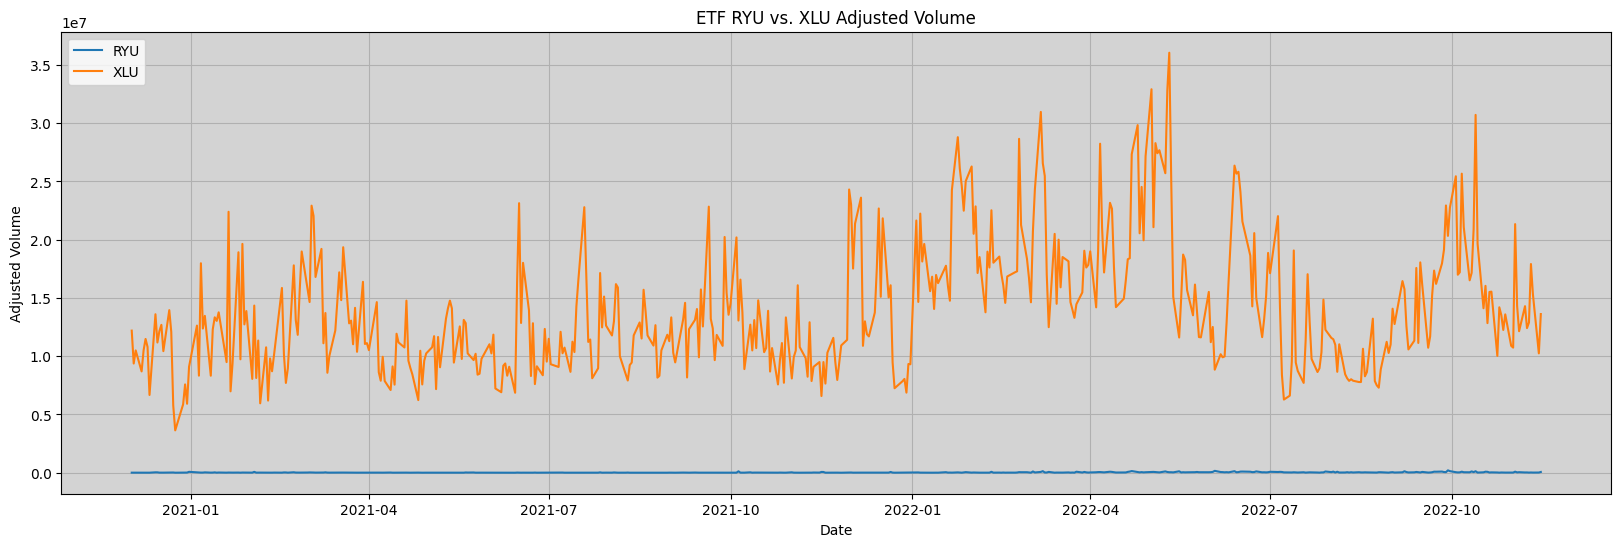

In [5]:
plt.figure(figsize=(20, 6))
plt.plot(RYU['adj_volume'], label='RYU')
plt.plot(XLU['adj_volume'], label='XLU')
plt.xlabel('Date')
plt.ylabel('Adjusted Volume')
plt.title('ETF RYU vs. XLU Adjusted Volume')
plt.gca().set_facecolor('lightgray')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

Comments: based on the daily adjusted volume plot of both RYU and XLU, XLU appears to be less liquid

    b. Plot the running median of XLU

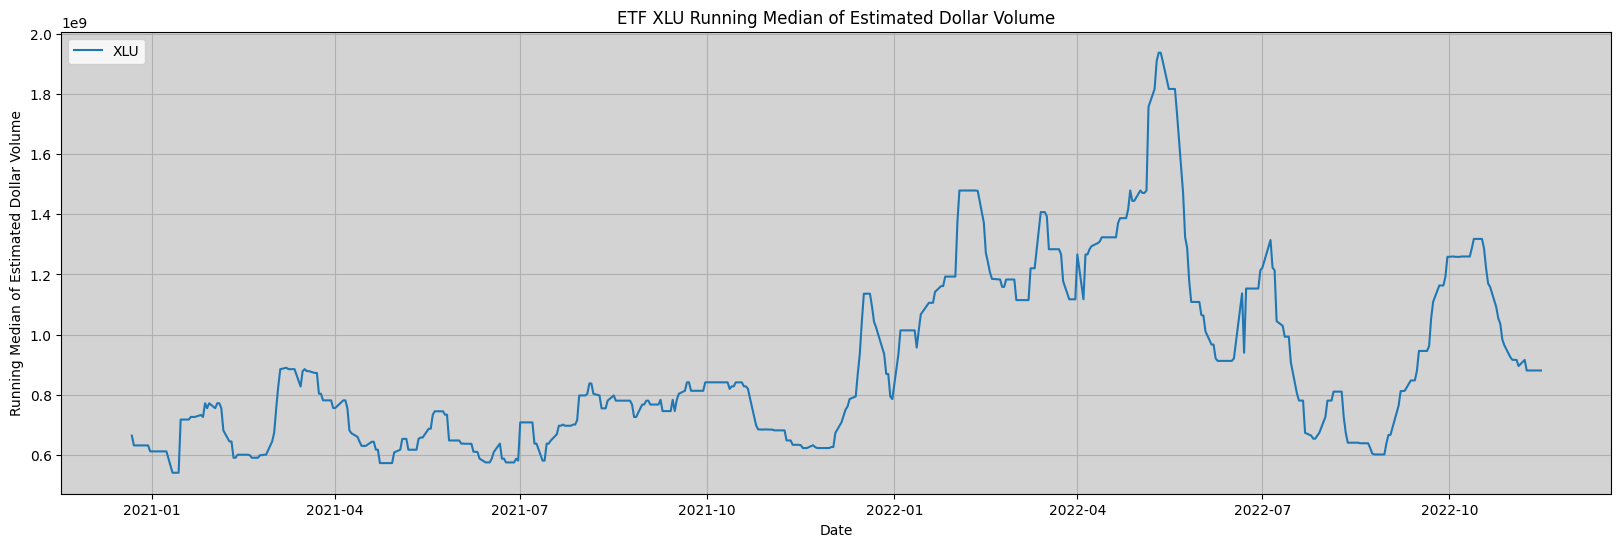

In [6]:
plt.figure(figsize=(20, 6))
plt.plot(XLU['Nt'], label='XLU')
plt.xlabel('Date')
plt.ylabel('Running Median of Estimated Dollar Volume')
plt.title('ETF XLU Running Median of Estimated Dollar Volume')
plt.gca().set_facecolor('lightgray')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

        c. Plot the adjusted close price of both RYU and XLU

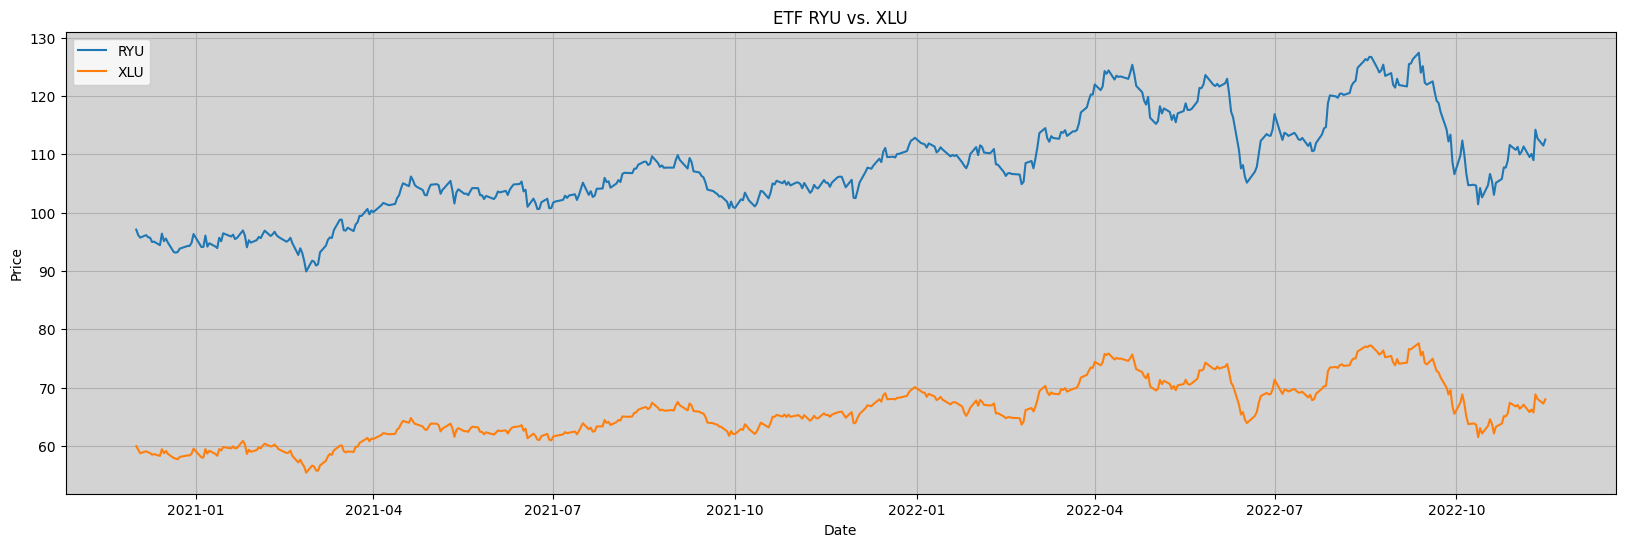

In [7]:
plt.figure(figsize=(20, 6))
plt.plot(RYU['adj_close'], label='RYU')
plt.plot(XLU['adj_close'], label='XLU')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('ETF RYU vs. XLU')
plt.gca().set_facecolor('lightgray')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

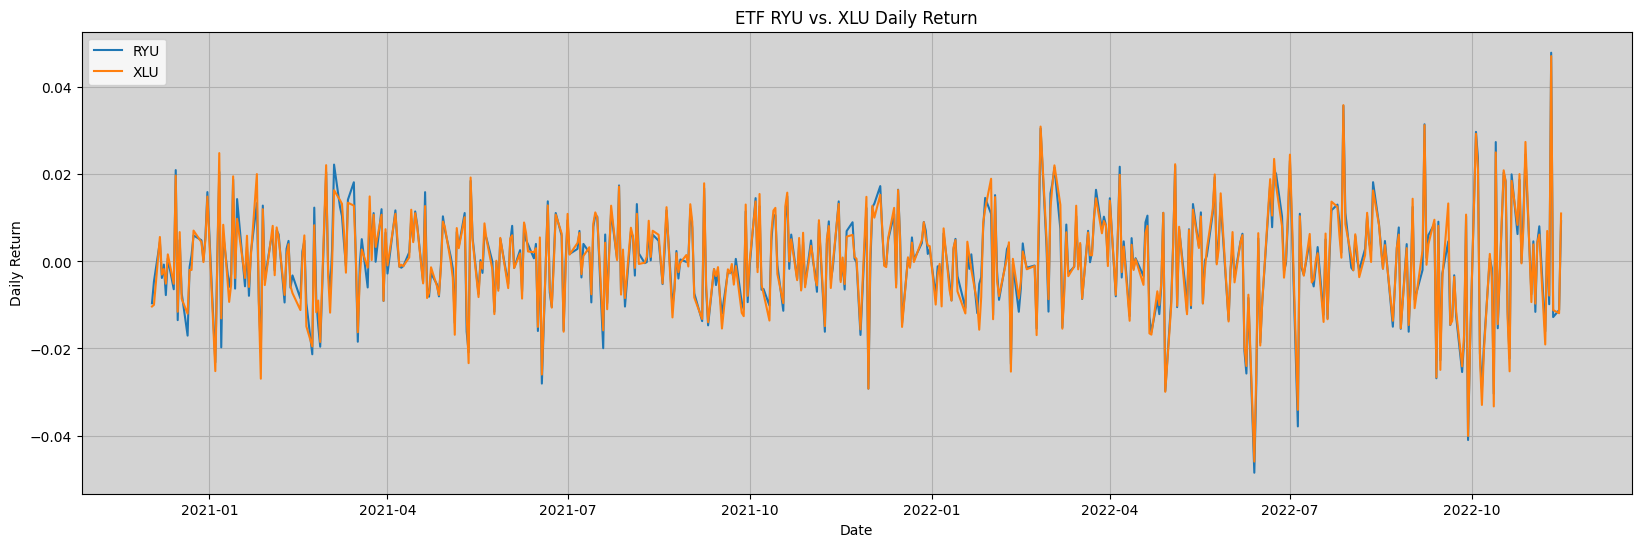

In [8]:
plt.figure(figsize=(20, 6))
plt.plot(RYU['daily_return'], label='RYU')
plt.plot(XLU['daily_return'], label='XLU')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.title('ETF RYU vs. XLU Daily Return')
plt.gca().set_facecolor('lightgray')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

### 3. Obtain daily Fama-French factor returns

In [9]:
url = "http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip"

fama_french = pd.read_csv('F-F_Research_Data_Factors_daily.csv', skiprows=4)
fama_french = fama_french[:-1]
fama_french['Unnamed: 0'] = pd.to_datetime(fama_french['Unnamed: 0'], format='%Y%m%d')
fama_french.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
fama_french.set_index('date', inplace=True)
fama_french = fama_french.fillna(method='ffill')


start_date = "2020-12-02"
end_date = "2022-11-15"
fama_french = fama_french[start_date:end_date]

fama_french

,Mkt-RF,SMB,HML,RF
date,,,,
2020-12-02,0.11,-0.09,1.07,0.000
2020-12-03,0.18,0.50,-0.09,0.000
2020-12-04,1.02,1.47,0.84,0.000
2020-12-07,0.03,0.24,-1.02,0.000
2020-12-08,0.47,1.02,-0.71,0.000
...,...,...,...,...
2022-11-09,-2.25,-0.62,0.55,0.014
2022-11-10,5.68,1.66,-3.11,0.014
2022-11-11,1.07,0.29,-1.08,0.014


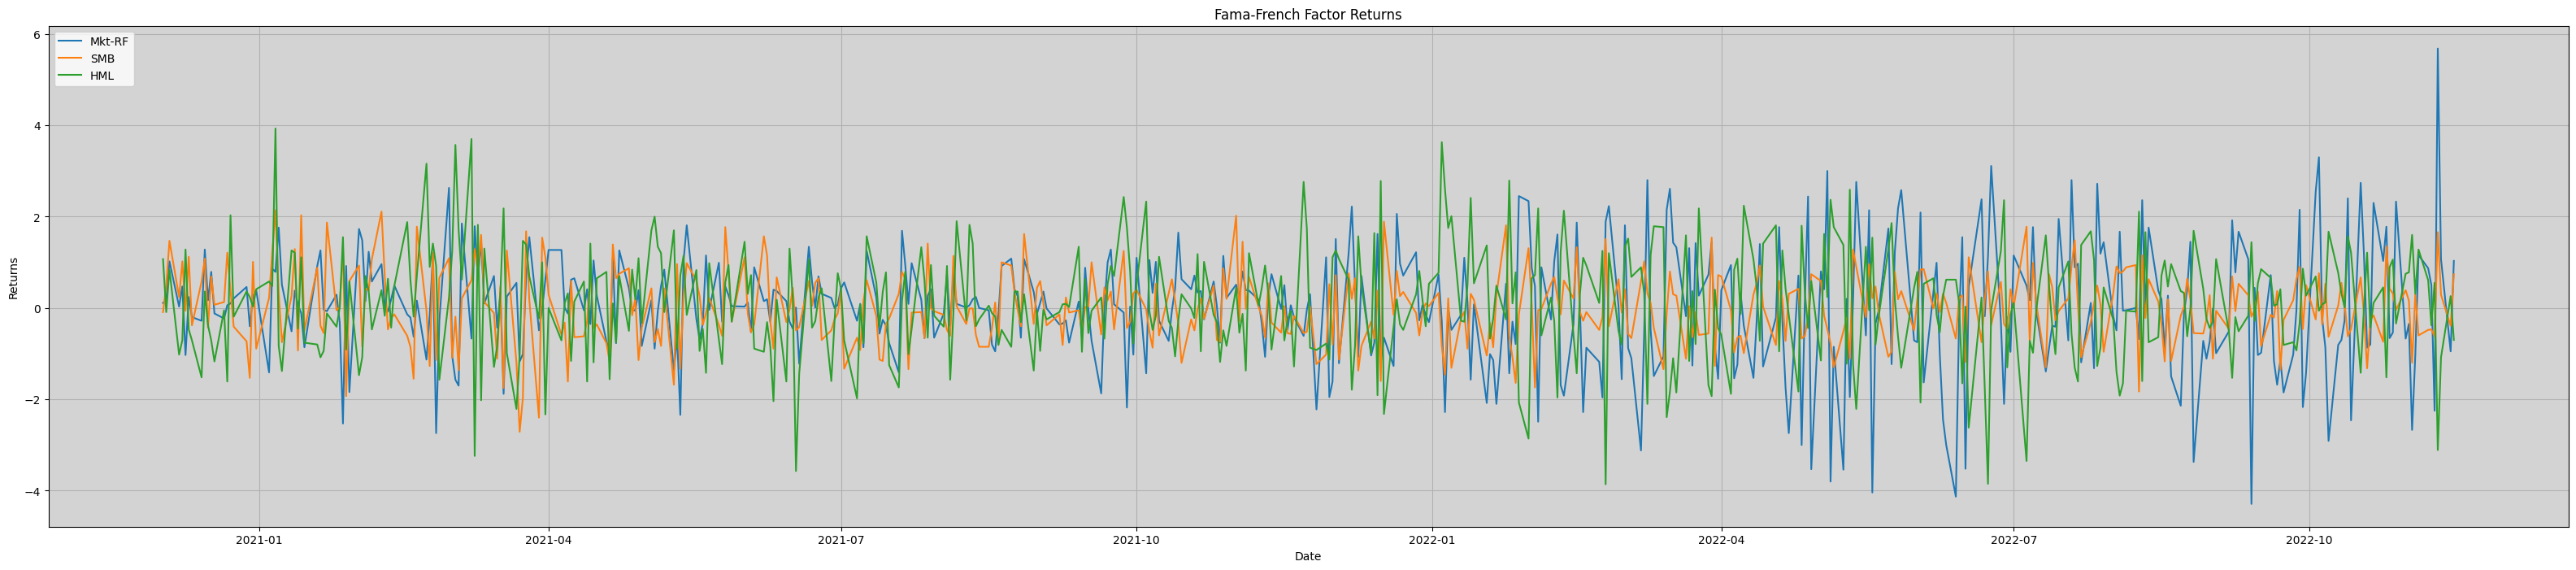

In [10]:
plt.figure(figsize=(40, 8))

plt.plot(fama_french['Mkt-RF'], label='Mkt-RF')
plt.plot(fama_french['SMB'], label='SMB')
plt.plot(fama_french['HML'], label='HML')
plt.grid(True)
plt.title("Fama-French Factor Returns")

plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend(loc='upper left')

plt.gca().set_facecolor('lightgray')
plt.show()


In [ ]:
merged_df = pd.merge(RYU, fama_french)

# Calculate the correlation between the spread and each Fama French factor
spread_mkt = pearsonr(merged_df['spread'], merged_df['Mkt-RF'])
spread_smb = pearsonr(merged_df['spread'], merged_df['SMB'])
spread_hml = pearsonr(merged_df['spread'], merged_df['HML'])

print(f"Spread vs Mkt-RF: Correlation={spread_mkt[0]:.3f}, p-value={spread_mkt[1]:.3f}")
print(f"Spread vs SMB: Correlation={spread_smb[0]:.3f}, p-value={spread_smb[1]:.3f}")
print(f"Spread vs HML: Correlation={spread_hml[0]:.3f}, p-value={spread_hml[1]:.3f}")

## Exercise

### 1. Positions

    a. Pull historical data

In [11]:
# Authenticate with Quandl API
quandl.ApiConfig.api_key = "vBX2yLsVUpn1kpJE_Hss"

etf_X = 'RYU'
etf_Y = 'XLU'

start_date = "2018-12-02"
end_date = "2020-11-15"


his_RYU = quandl.get_table('QUOTEMEDIA/PRICES', date = { 'gte': start_date, 'lte': end_date }, ticker=etf_X)
his_XLU = quandl.get_table('QUOTEMEDIA/PRICES', date = { 'gte': start_date, 'lte': end_date }, ticker=etf_Y)

In [12]:
his_RYU = his_RYU.sort_values('date')
his_RYU['date'] = pd.to_datetime(his_RYU['date'])
his_RYU.set_index('date', inplace=True)
his_RYU['daily_return'] = his_RYU['adj_close'].pct_change()
his_RYU['est_$volume'] = his_RYU['adj_close'] * his_RYU['adj_volume']
his_RYU['Nt'] = his_RYU['est_$volume'].rolling(window=15).median()

his_XLU = his_XLU.sort_values('date')
his_XLU['date'] = pd.to_datetime(his_XLU['date'])
his_XLU.set_index('date', inplace=True)
his_XLU['daily_return'] = his_XLU['adj_close'].pct_change()
his_XLU['est_$volume'] = his_XLU['adj_close'] * his_RYU['adj_volume']
his_XLU['Nt'] = his_RYU['est_$volume'].rolling(window=15).median()

In [13]:
his_data = his_RYU['adj_close'].to_frame('RYU price')
his_data['XLU price'] = his_XLU['adj_close']
his_data['spread'] = his_RYU['daily_return'] - his_XLU['daily_return']
his_data['Nt'] = his_XLU['Nt']
his_data

,RYU price,XLU price,spread,Nt
date,,,,
2018-12-03,84.208006,49.472802,NaN,NaN
2018-12-04,84.398022,49.508045,0.001544,NaN
2018-12-06,84.324683,49.560910,-0.001937,NaN
2018-12-07,85.088079,49.745938,0.005320,NaN
2018-12-10,85.341433,49.842857,0.001029,NaN
...,...,...,...,...
2020-11-09,99.632581,61.511254,0.007177,9.313116e+05
2020-11-10,101.200233,62.396443,0.001344,9.313116e+05
2020-11-11,101.132611,62.631866,-0.004441,9.585317e+05


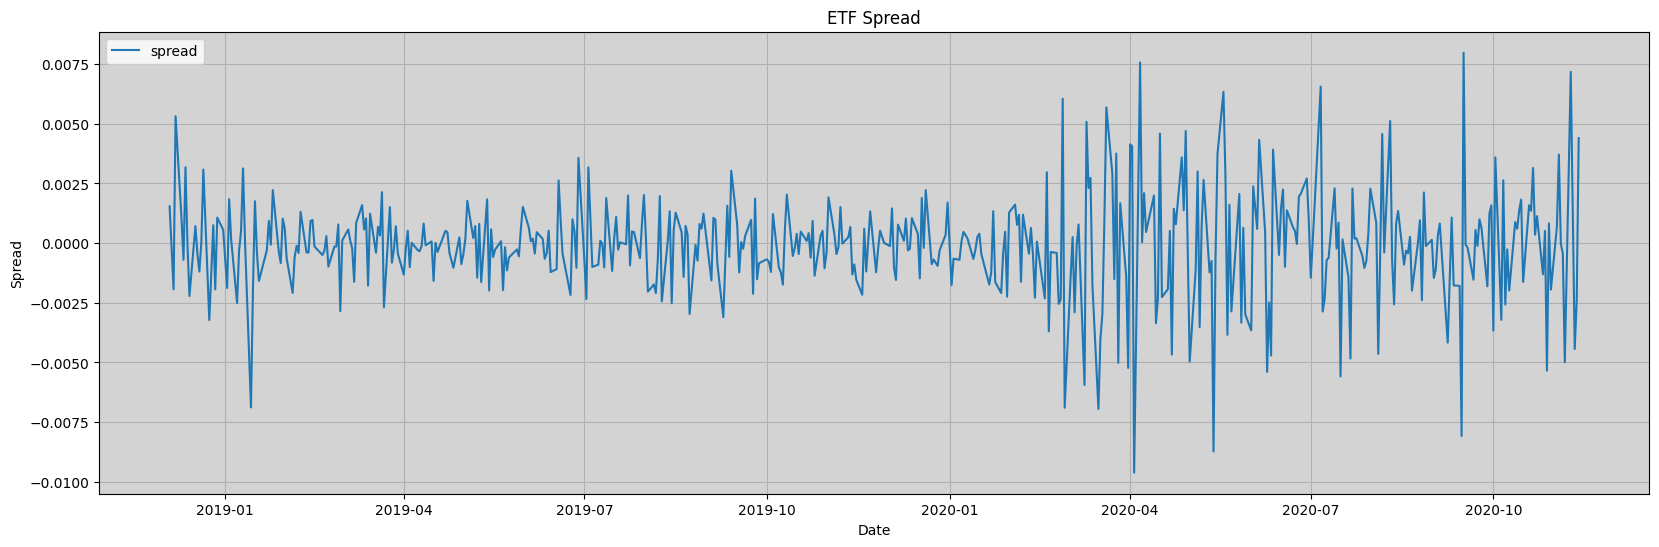

In [14]:
plt.figure(figsize=(20, 6))
plt.plot(his_data['spread'], label='spread')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.title('ETF Spread')
plt.gca().set_facecolor('lightgray')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

    b. Analysis of the historical spread performance

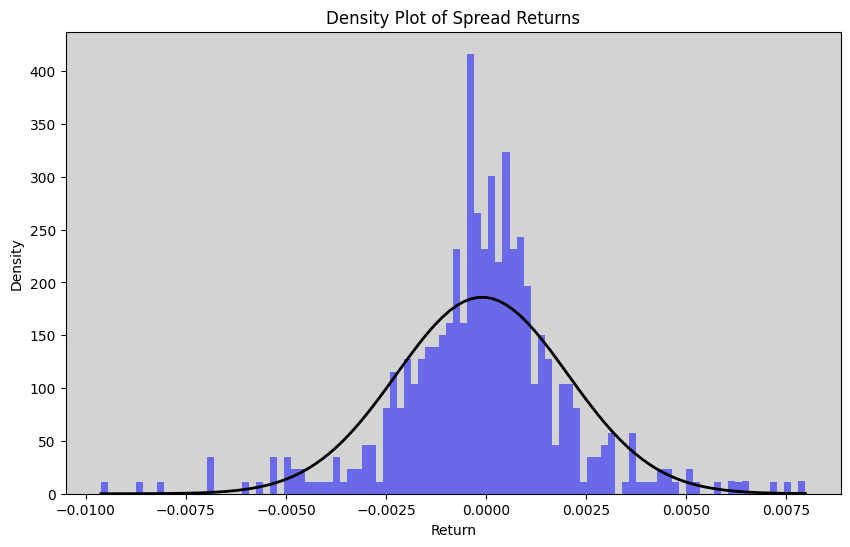

In [15]:
# calculate mean and standard deviation
mean = his_data['spread'].mean()
std = his_data['spread'].std()
xmin = his_data['spread'].min()
xmax = his_data['spread'].max()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std)

# create a normal distribution with the same mean and standard deviation
plt.figure(figsize=(10, 6))
plt.hist(his_data['spread'], density=True, bins=100, color='blue', alpha=0.5)
plt.xlabel('Return')
plt.ylabel('Density')
plt.title('Density Plot of Spread Returns')

plt.plot(x, p, 'k', linewidth=2)

plt.gca().set_facecolor('lightgray')

# display the plot
plt.show()

Comments: though not normally distributed, we can see from the chart that above 95% of the observations will fall within 2 standard deviations of the mean. 

In [16]:
# Perform the ADF test
result = adfuller(his_data['spread'].dropna())

# Print the test statistic and p-value
print('ADF test statistic:', result[0])
print('p-value:', result[1])

ADF test statistic: -13.141751995531221
p-value: 1.4246885175317202e-24


comments: A p-value less than the significance level (usually 0.05) suggests that the time series is stationary and mean-reverting.

Spread-reversion trading strategy is based on the idea that the spread between two assets tends to revert to its mean over time. So, when the spread between two assets becomes too large, it is likely to decrease in the future, and when the spread becomes too small, it is likely to increase in the future.

Taking two standard deviations (2σ) as the entry point for a spread-reversion trade is a way to identify when the spread is unusually large or small compared to its historical behavior.  When the spread exceeds 2σ, it is considered to be an unusually large deviation from the mean, and a good opportunity to enter a spread-reversion trade.

Thus, it make sense to test the spread-reversion trading strategy using parameters historical mean and std.

Market background analysis: 

In 2020, the global economy was heavily impacted by the COVID-19 pandemic, which led to widespread economic disruption and market volatility. Many industries experienced significant declines in activity and revenue, and governments around the world implemented measures such as lockdowns and stimulus packages to try to mitigate the impact of the pandemic.

As a result of the pandemic and related economic turmoil, the performance of different sectors of the stock market varied widely in 2020. In general, technology and healthcare sectors tended to perform relatively well, while energy, travel and leisure, and brick-and-mortar retail sectors were hit hard.

RYU and XLU are ETFs that track the performance of specific sectors of the stock market. RYU tracks the performance of companies involved in the renewable energy sector, while XLU tracks the performance of companies in the utilities sector.

As renewable energy is a growing industry and utilities are considered as defensive stocks, it's likely that RYU will continue to perform well in 2021 and 2022. However, the exact trend of the spread between RYU and XLU is difficult to predict with certainty as it depends on the overall economic conditions and how the renewable energy industry performs relative to the utilities sector.

Thus, the spread performance from Dec 2020 though 15 Nov 2022 will likely more resamble to the historical performance from 2020 late march to 2020 dec.

In [17]:
his_data['spread']['2020-03-20':].describe()

count    167.000000
mean       0.000008
std        0.002961
min       -0.009624
25%       -0.001582
50%        0.000186
75%        0.001583
max        0.007979
Name: spread, dtype: float64

### 2. Trading Simulation using historical data:

    a. Building historical data to test on

In [18]:
his_data

,RYU price,XLU price,spread,Nt
date,,,,
2018-12-03,84.208006,49.472802,NaN,NaN
2018-12-04,84.398022,49.508045,0.001544,NaN
2018-12-06,84.324683,49.560910,-0.001937,NaN
2018-12-07,85.088079,49.745938,0.005320,NaN
2018-12-10,85.341433,49.842857,0.001029,NaN
...,...,...,...,...
2020-11-09,99.632581,61.511254,0.007177,9.313116e+05
2020-11-10,101.200233,62.396443,0.001344,9.313116e+05
2020-11-11,101.132611,62.631866,-0.004441,9.585317e+05


    b. Building simulator

In [26]:
def trading_simulation(data, M, g, j, s):
    # Initialize variables
    X_ret = data['RYU price'].pct_change(M)
    Y_ret = data['XLU price'].pct_change(M)
    spread = X_ret - Y_ret

    position = 0 # 0 for flat, 1 for long, -1 for short
    trade_size_X = 0
    trade_size_Y = 0
    pnl = 0
    month = 12
    month_start = True

    for i in range(len(data[:'2019-01-01'])+1,len(data)):
        
        Nt = data['Nt'][i]
        gross_traded_cash = 2 * Nt / 100
        # Calculate the size of difference z between the M-day return on X and Y
        z = spread[i]
        mark = ''
        
        if data.index[i].month != month:
            month = data.index[i].month
            month_start = True

        if month_start:
            if z > g:
                # Enter position: short X, long Y (short position)
                trade_size_X = - int(Nt / 100 / data['RYU price'][i])
                trade_size_Y = int(Nt / 100 / data['XLU price'][i])
                cur_value = trade_size_X * data['RYU price'][i] + trade_size_Y * data['XLU price'][i]
                position = -1
                mark = 'sell'
                month_start = False
            elif z < -g:
                # Enter position: long X, short Y (long position)
                trade_size_X = int(Nt / 100 / data['RYU price'][i])
                trade_size_Y = - int(Nt / 100 / data['XLU price'][i])
                cur_value = trade_size_X * data['RYU price'][i] + trade_size_Y * data['XLU price'][i]
                position = 1
                mark = 'buy'
                month_start = False
            else:
                continue
        else:
            #Checking for stop loss (if traded cash go below s portion, close position)
            if position != 0:
                if (pnl + trade_size_X * data['RYU price'][i] + trade_size_Y * data['XLU price'][i]) < -s * gross_traded_cash:
                    pnl += trade_size_X * data['RYU price'][i] + trade_size_Y * data['XLU price'][i] - cur_value
                    position = 0
                    mark = 'stop loss'
                    continue
                if i+1 < len(data) and data.index[i].month != data.index[i+1].month:
               # Close position
                    pnl += trade_size_X * data['RYU price'][i] + trade_size_Y * data['XLU price'][i] - cur_value
                    position = 0
                    mark = 'close'
                    continue
                #Checking if spread fall between the flat condition
                if -j < z < g and position == 1:
                    pnl += trade_size_X * data['RYU price'][i] + trade_size_Y * data['XLU price'][i] - cur_value
                    trade_size_X = 0
                    trade_size_Y = 0
                    cur_value = 0
                    position = 0
                    mark = 'flat'
                if -g < z < j and position == -1:
                    pnl += trade_size_X * data['RYU price'][i] + trade_size_Y * data['XLU price'][i] - cur_value
                    trade_size_X = 0
                    trade_size_Y = 0
                    cur_value = 0
                    position = 0
                    mark = 'flat'
                #Checking if spread fall between the flipping condition
                if z < -g and position == -1:
                    pnl += trade_size_X * data['RYU price'][i] + trade_size_Y * data['XLU price'][i] - cur_value
                    trade_size_X = int(Nt / 100 / data['RYU price'][i])
                    trade_size_Y = - int(Nt / 100 / data['XLU price'][i])
                    cur_value = trade_size_X * data['RYU price'][i] + trade_size_Y * data['XLU price'][i]
                    position = 1
                    mark = 'buy'
                if z > g and position == 1:
                    pnl += trade_size_X * data['RYU price'][i] + trade_size_Y * data['XLU price'][i] - cur_value
                    trade_size_X = - int(Nt / 100 / data['RYU price'][i])
                    trade_size_Y = int(Nt / 100 / data['XLU price'][i])
                    cur_value = trade_size_X * data['RYU price'][i] + trade_size_Y * data['XLU price'][i]
                    position = -1
                    mark = 'sell'
            # Check if current day is the last day of the month
        pnl += trade_size_X * data['RYU price'][i] + trade_size_Y * data['XLU price'][i] - cur_value
        cur_value = trade_size_X * data['RYU price'][i] + trade_size_Y * data['XLU price'][i]
    return pnl

    c. Testing using 1-15 days spread, and g, j using different combination of mean and std based on historical data. 

In [27]:
key = []
l = []
for m in range(1,15,1):
    mean = his_data['spread']['2020-03-20':].mean()
    std = his_data['spread']['2020-03-20':].std()
    for i in np.arange(0.5,2,0.1):
        g = mean + 2 * i * std
        j = mean + 1 * i * std
        pnl = trading_simulation(his_data['2020-03-20':], m, g , j, 0.01 )
        key.append([m,g.round(10),j.round(10), 0.01])
        l.append(pnl)
df = pd.DataFrame(list(zip(key, l)), columns = ['parameter', 'PnL'])
df.set_index('parameter').sort_values('PnL', ascending = False).head(10)

,PnL
parameter,
"[5, 0.0029689343, 0.0014882513, 0.01]",984.875521
"[1, 0.0029689343, 0.0014882513, 0.01]",891.613253
"[9, 0.0029689343, 0.0014882513, 0.01]",859.258198
"[1, 0.0035612076, 0.0017843879, 0.01]",851.975944
"[2, 0.0059303004, 0.0029689343, 0.01]",800.926534
"[7, 0.0071148468, 0.0035612076, 0.01]",790.218234
"[9, 0.0035612076, 0.0017843879, 0.01]",786.988135
"[2, 0.004745754, 0.0023766611, 0.01]",766.608154
"[2, 0.0053380272, 0.0026727977, 0.01]",761.813839


    d.  Testing using 1-15 days spread, and g, j using different combination of mean and std based on data from Dec 2020 though 15 Nov 2022.

In [79]:
data = RYU['adj_close'].to_frame('RYU price')
data['XLU price'] = XLU['adj_close']
data['spread'] = RYU['daily_return'] - XLU['daily_return']
data['Nt'] = XLU['Nt']
data.dropna(inplace=True)
data

,RYU price,XLU price,spread,Nt
date,,,,
2020-12-22,93.133476,57.839363,0.000669,6.646548e+08
2020-12-23,93.268271,57.725394,0.003418,6.320617e+08
2020-12-24,93.825069,58.133784,-0.001105,6.320617e+08
2020-12-28,94.279809,58.390214,0.000436,6.320617e+08
2020-12-29,94.298487,58.380717,0.000361,6.320617e+08
...,...,...,...,...
2022-11-09,108.977000,65.750000,-0.001993,8.809535e+08
2022-11-10,114.200000,68.850000,0.000779,8.809535e+08
2022-11-11,112.740000,68.080000,-0.001601,8.809535e+08


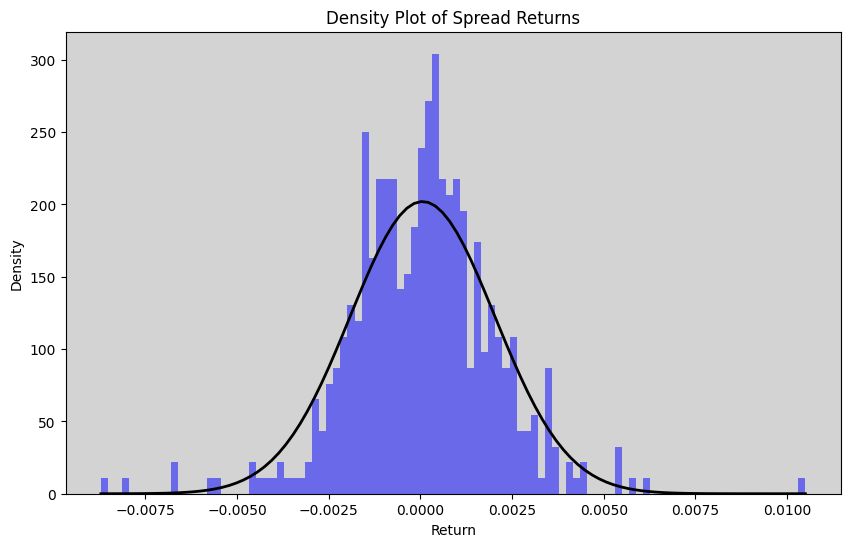

In [78]:
# calculate mean and standard deviation
mean = data['spread'].mean()
std = data['spread'].std()
xmin = data['spread'].min()
xmax = data['spread'].max()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std)

# create a normal distribution with the same mean and standard deviation
plt.figure(figsize=(10, 6))
plt.hist(data['spread'], density=True, bins=100, color='blue', alpha=0.5)
plt.xlabel('Return')
plt.ylabel('Density')
plt.title('Density Plot of Spread Returns')

plt.plot(x, p, 'k', linewidth=2)

plt.gca().set_facecolor('lightgray')

# display the plot
plt.show()

In [32]:
data['spread'].describe()

count    479.000000
mean       0.000056
std        0.001974
min       -0.008715
25%       -0.001175
50%        0.000111
75%        0.001166
max        0.010498
Name: spread, dtype: float64

In [33]:
key = []
l = []
for m in range(1,15,1):
    mean = data['spread'].mean()
    std = data['spread'].std()
    for i in np.arange(0.5,2,0.1):
        g = mean + 2 * i * std
        j = mean + 1 * i * std
        pnl = trading_simulation(data, m, g , j, 0.01 )
        key.append([m,g.round(10),j.round(10), 0.01])
        l.append(pnl)
df2 = pd.DataFrame(list(zip(key, l)), columns = ['parameter', 'PnL'])
df2.set_index('parameter').sort_values('PnL', ascending = False).head(10)

,PnL
parameter,
"[8, 0.0040047599, 0.002030542, 0.01]",328707.015284
"[5, 0.0024253856, 0.0012408548, 0.01]",305939.316081
"[8, 0.0043996034, 0.0022279638, 0.01]",288266.397602
"[7, 0.004794447, 0.0024253856, 0.01]",263570.056787
"[6, 0.0040047599, 0.002030542, 0.01]",222243.957214
"[5, 0.002030542, 0.0010434331, 0.01]",220699.088654
"[7, 0.0043996034, 0.0022279638, 0.01]",210700.356550
"[8, 0.0036099163, 0.0018331202, 0.01]",203615.876702
"[6, 0.0032150727, 0.0016356984, 0.01]",203212.994182


### 3. Trading Strategy with Data from Dec 2020 though 15 Nov 2022

In [59]:
def spread_reversion_strategy(data, M, g, j, s):
    # Initialize variables
    X_ret = data['RYU price'].pct_change(M)
    Y_ret = data['XLU price'].pct_change(M)
    spread = X_ret - Y_ret

    position = 0 # 0 for flat, 1 for long, -1 for short
    mark = ''
    trade_size_X = 0
    trade_size_Y = 0
    pnl = 0
    month = 12
    month_start = True
    res = []

    for i in range(len(data[:'2021-01-01'])+1,len(data)):
        
        Nt = data['Nt'][i]
        gross_traded_cash = 2 * Nt / 100
        # Calculate the size of difference z between the M-day return on X and Y
        z = spread[i]

        res.append({'date': data.index[i], 'RYU price': data['RYU price'][i], 'XLU price': data['XLU price'][i], 
        'spread':z, 'position': position, 'trade': mark, 'trade_size_X': trade_size_X, 'trade_size_Y': trade_size_Y, 'cumulative pnl': pnl})

        mark = ''
        
        if data.index[i].month != month:
            month = data.index[i].month
            month_start = True

        if month_start:
            if z > g:
                # Enter position: short X, long Y (short position)
                trade_size_X = - int(Nt / 100 / data['RYU price'][i])
                trade_size_Y = int(Nt / 100 / data['XLU price'][i])
                cur_value = trade_size_X * data['RYU price'][i] + trade_size_Y * data['XLU price'][i]
                position = -1
                mark = 'sell'
                month_start = False
            elif z < -g:
                # Enter position: long X, short Y (long position)
                trade_size_X = int(Nt / 100 / data['RYU price'][i])
                trade_size_Y = - int(Nt / 100 / data['XLU price'][i])
                cur_value = trade_size_X * data['RYU price'][i] + trade_size_Y * data['XLU price'][i]
                position = 1
                mark = 'buy'
                month_start = False
            else:
                continue
        else:
            #Checking for stop loss (if traded cash go below s portion, close position)
            if position != 0:
                if (pnl + trade_size_X * data['RYU price'][i] + trade_size_Y * data['XLU price'][i]) < -s * gross_traded_cash:
                    pnl += trade_size_X * data['RYU price'][i] + trade_size_Y * data['XLU price'][i] - cur_value
                    position = 0
                    mark = 'stop loss'
                    continue
                if i+1 < len(data) and data.index[i].month != data.index[i+1].month:
               # Close position
                    pnl += trade_size_X * data['RYU price'][i] + trade_size_Y * data['XLU price'][i] - cur_value
                    position = 0
                    mark = 'close'
                    continue
                #Checking if spread fall between the flat condition
                if -j < z < g and position == 1:
                    pnl += trade_size_X * data['RYU price'][i] + trade_size_Y * data['XLU price'][i] - cur_value
                    trade_size_X = 0
                    trade_size_Y = 0
                    cur_value = 0
                    position = 0
                    mark = 'flat'
                if -g < z < j and position == -1:
                    pnl += trade_size_X * data['RYU price'][i] + trade_size_Y * data['XLU price'][i] - cur_value
                    trade_size_X = 0
                    trade_size_Y = 0
                    cur_value = 0
                    position = 0
                    mark = 'flat'
                #Checking if spread fall between the flipping condition
                if z < -g and position == -1:
                    pnl += trade_size_X * data['RYU price'][i] + trade_size_Y * data['XLU price'][i] - cur_value
                    trade_size_X = int(Nt / 100 / data['RYU price'][i])
                    trade_size_Y = - int(Nt / 100 / data['XLU price'][i])
                    cur_value = trade_size_X * data['RYU price'][i] + trade_size_Y * data['XLU price'][i]
                    position = 1
                    mark = 'buy'
                if z > g and position == 1:
                    pnl += trade_size_X * data['RYU price'][i] + trade_size_Y * data['XLU price'][i] - cur_value
                    trade_size_X = - int(Nt / 100 / data['RYU price'][i])
                    trade_size_Y = int(Nt / 100 / data['XLU price'][i])
                    cur_value = trade_size_X * data['RYU price'][i] + trade_size_Y * data['XLU price'][i]
                    position = -1
                    mark = 'sell'
            # Check if current day is the last day of the month
        pnl += trade_size_X * data['RYU price'][i] + trade_size_Y * data['XLU price'][i] - cur_value
        cur_value = trade_size_X * data['RYU price'][i] + trade_size_Y * data['XLU price'][i]
    return res

### #1 Trading using M = 5, g = 0.00297, j = 0.00148, stop loss = 1% (Best Perfoming using historical data)

In [63]:
res1 = spread_reversion_strategy(data, 5, 0.00297 , 0.00148, 0.01 )
res1_df = pd.DataFrame(res1, columns=['date', 'RYU price', 'XLU price', 'spread', 'position', 'trade', 'trade_size_X', 'trade_size_Y', 'cumulative pnl']).set_index('date')
res1_df['ret'] = res1_df['cumulative pnl'] - res1_df['cumulative pnl'].shift()
res1_df

,RYU price,XLU price,spread,position,trade,trade_size_X,trade_size_Y,cumulative pnl,ret
date,,,,,,,,,
2021-01-05,94.134808,58.038809,0.004480,0,,0,0,0.000000,NaN
2021-01-06,96.070074,59.482419,-0.000084,-1,sell,-65040,105491,0.000000,0.000000
2021-01-07,94.173321,58.703630,-0.007311,0,flat,0,0,26418.127873,26418.127873
2021-01-08,94.751012,59.197496,-0.010491,0,,0,0,26418.127873,0.000000
2021-01-11,94.196717,58.646645,-0.009240,0,,0,0,26418.127873,0.000000
...,...,...,...,...,...,...,...,...,...
2022-11-09,108.977000,65.750000,0.000610,0,,0,0,179166.166397,0.000000
2022-11-10,114.200000,68.850000,0.001502,0,,0,0,179166.166397,0.000000
2022-11-11,112.740000,68.080000,-0.002091,0,,0,0,179166.166397,0.000000


In [65]:
res1_df.describe()

,RYU price,XLU price,spread,position,trade_size_X,trade_size_Y,cumulative pnl,ret
count,471.000000,471.000000,471.000000,471.000000,471.000000,471.000000,471.000000,470.000000
mean,108.389264,66.281419,0.000264,-0.010616,-3086.796178,5159.138004,168314.995778,381.204609
std,8.270361,4.849493,0.004064,0.430109,43288.531180,71064.181245,79502.011497,7950.627932
min,89.917661,55.427015,-0.012532,-1.000000,-163064.000000,-217806.000000,0.000000,-48708.472303
25%,103.033332,62.835793,-0.002346,0.000000,0.000000,0.000000,98388.288424,0.000000
50%,106.990000,65.630610,0.000092,0.000000,0.000000,0.000000,159227.874248,0.000000
75%,113.185000,69.400233,0.002573,0.000000,0.000000,0.000000,247548.848343,0.000000
max,127.400000,77.601346,0.014970,1.000000,132590.000000,271015.000000,286332.430068,44857.272208


    Daily Return Plot

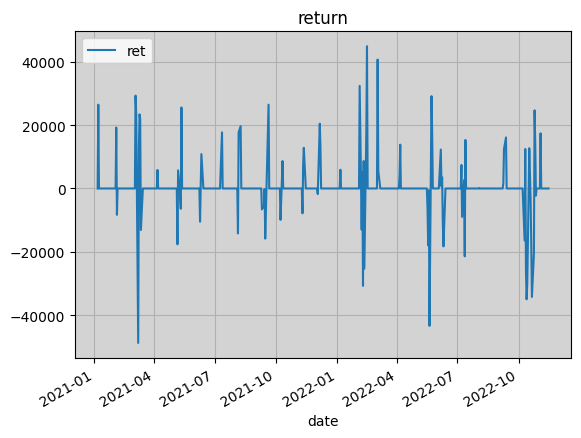

In [69]:
res1_df.plot(y='ret')
plt.title('return')
plt.gca().set_facecolor('lightgray')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

    Cumulative PnL Plot

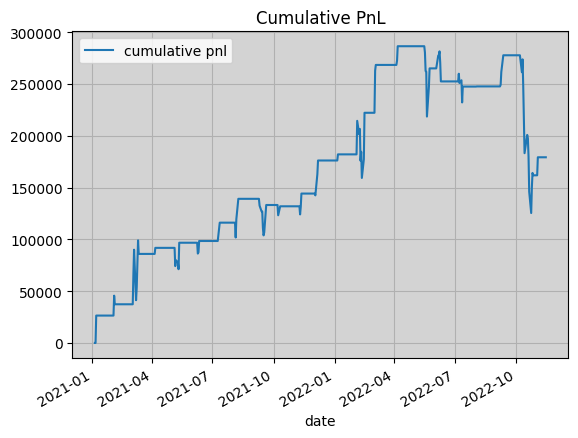

In [53]:
res1_df.plot(y='cumulative pnl')
plt.title('Cumulative PnL')
plt.gca().set_facecolor('lightgray')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

    Trading Position Plot

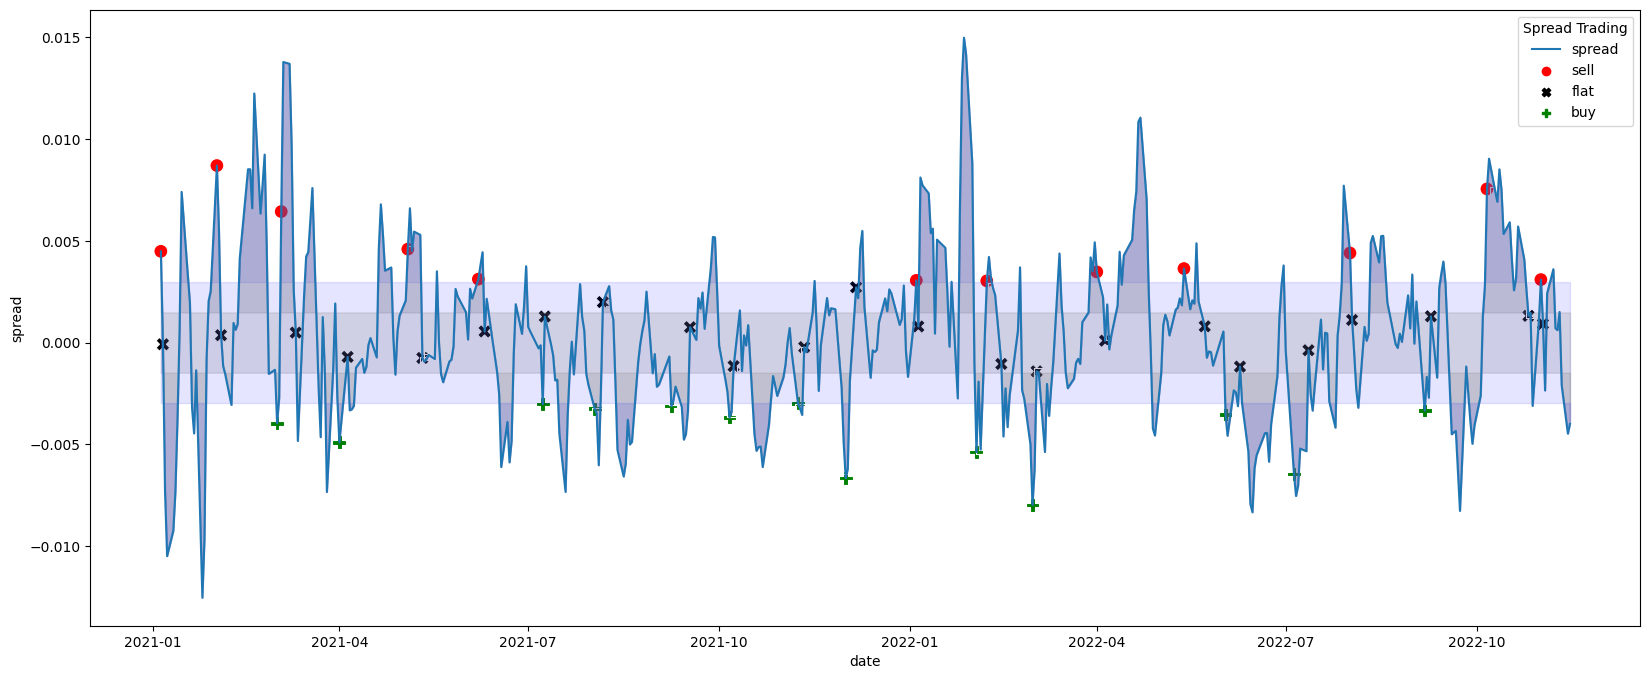

In [43]:
res1_df['trade'] = res1_df['trade'].shift(-1)
plt.figure(figsize=(20, 8))
sns.lineplot(x='date', y='spread', data=res1_df, label='spread')
sns.scatterplot(x='date', y='spread', hue='trade', data=res1_df, marker='o', s=100, style='trade',palette={'buy':'green','sell':'red', 'flat': 'black'})
plt.fill_between(res1_df.index, res1_df['spread'], 0.00297, color='blue', alpha=0.1)
plt.fill_between(res1_df.index, res1_df['spread'], 0.00148, color='gray', alpha=0.2)
plt.fill_between(res1_df.index, res1_df['spread'], -0.00148, color='gray', alpha=0.2)
plt.fill_between(res1_df.index, res1_df['spread'], -0.00297, color='blue', alpha=0.1)
plt.legend(title='Spread Trading')
plt.show()

### #2 Trading using optimized parameter: M = 8, g = 0.004, j = 0.002, stop loss = 1% (Besting performing using data after Dec 2020 )

In [70]:
res3 = spread_reversion_strategy(data, 8, 0.004 , 0.002, 0.01 )
res3_df = pd.DataFrame(res3, columns=['date', 'RYU price', 'XLU price', 'spread', 'position', 'trade', 'trade_size_X', 'trade_size_Y', 'cumulative pnl']).set_index('date')
res3_df['trade'] = res3_df['trade'].shift(-1)
res3_df['ret'] = res3_df['cumulative pnl'] - res3_df['cumulative pnl'].shift()
res3_df

,RYU price,XLU price,spread,position,trade,trade_size_X,trade_size_Y,cumulative pnl,ret
date,,,,,,,,,
2021-01-05,94.134808,58.038809,0.007303,0,sell,0,0,0.000000,NaN
2021-01-06,96.070074,59.482419,-0.000397,-1,flat,-65040,105491,0.000000,0.000000
2021-01-07,94.173321,58.703630,-0.006091,0,,0,0,26418.127873,26418.127873
2021-01-08,94.751012,59.197496,-0.008828,0,,0,0,26418.127873,0.000000
2021-01-11,94.196717,58.646645,-0.005634,0,,0,0,26418.127873,0.000000
...,...,...,...,...,...,...,...,...,...
2022-11-09,108.977000,65.750000,0.001209,0,,0,0,328707.015284,20547.880000
2022-11-10,114.200000,68.850000,0.000154,0,,0,0,328707.015284,0.000000
2022-11-11,112.740000,68.080000,-0.002211,0,,0,0,328707.015284,0.000000


    Daily Return Plot

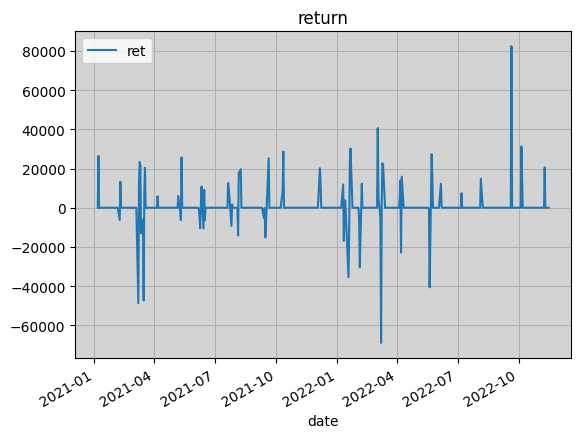

In [71]:
res3_df.plot(y='ret')
plt.title('return')
plt.gca().set_facecolor('lightgray')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

    PnL

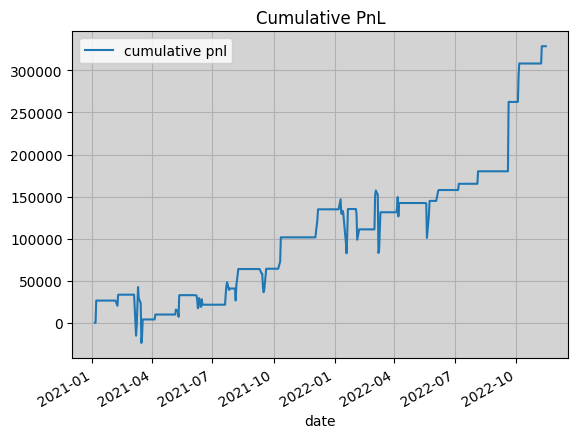

In [41]:
res3_df.plot(y='cumulative pnl')
plt.title('Cumulative PnL')
plt.gca().set_facecolor('lightgray')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

    Spread Trading Plot

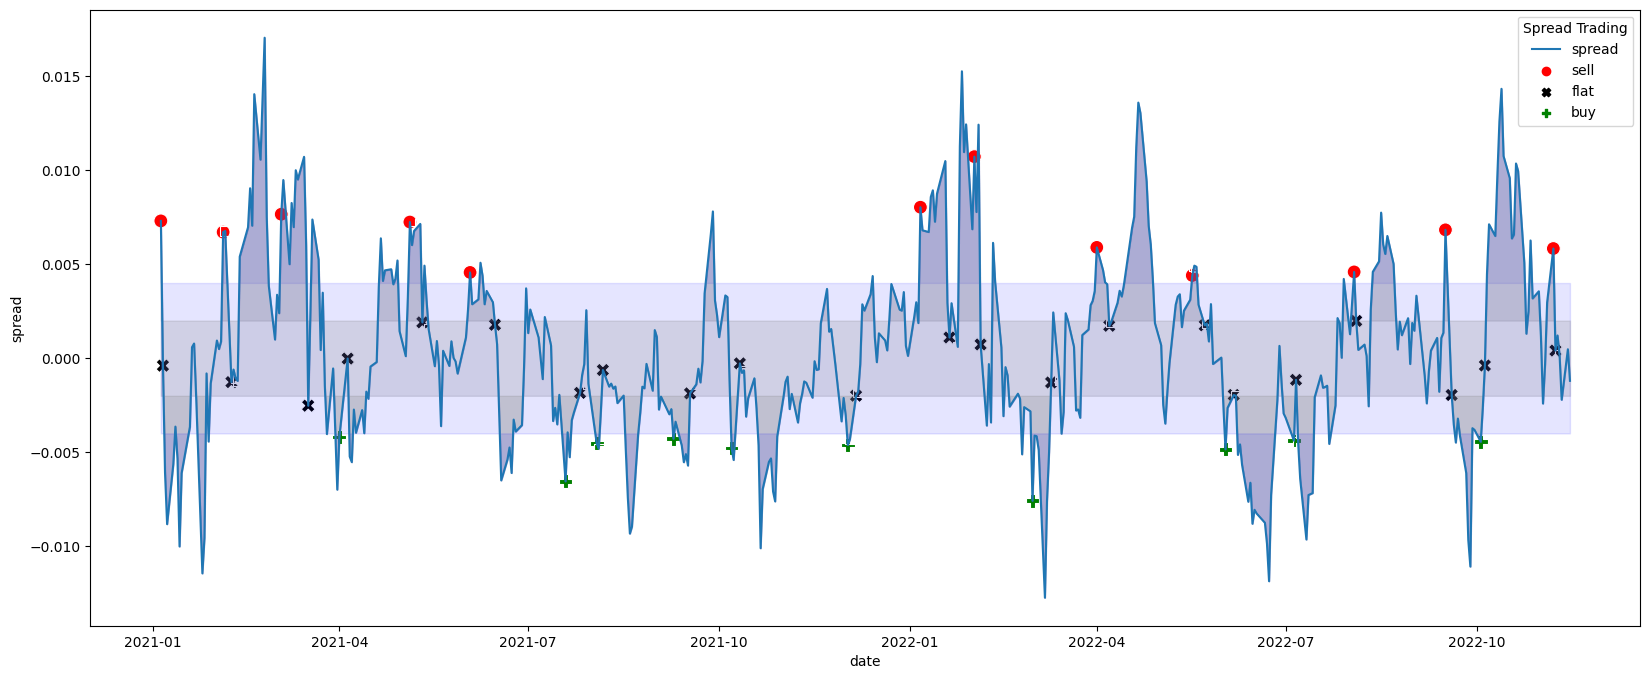

In [44]:
plt.figure(figsize=(20, 8))
sns.lineplot(x='date', y='spread', data=res3_df, label='spread')
sns.scatterplot(x='date', y='spread', hue='trade', data=res3_df, marker='o', s=100, style='trade',palette={'buy':'green','sell':'red', 'flat': 'black'})
plt.fill_between(res3_df.index, res3_df['spread'], 0.004, color='blue', alpha=0.1)
plt.fill_between(res3_df.index, res3_df['spread'], 0.002, color='gray', alpha=0.2)
plt.fill_between(res3_df.index, res3_df['spread'], -0.002, color='gray', alpha=0.2)
plt.fill_between(res3_df.index, res3_df['spread'], -0.004, color='blue', alpha=0.1)
plt.legend(title='Spread Trading')
plt.show()

### #3 Best Case: Trading with modified parameter M = 5, g = 0.00247, j = 0.00148, stop loss = 1%


### Analysis:

The parameter extracted from historical performance was calculated right after covid hit, so for trading from 2021 Jan to 2022 Nov, we are expecting the spread go less volatile, so I bring down the parameter g (-0.0005) slightly, to capture more trading opportunities.

In [75]:
res2 = spread_reversion_strategy(data, 5, 0.00247 , 0.00148, 0.01 )
res2_df = pd.DataFrame(res2, columns=['date', 'RYU price', 'XLU price', 'spread', 'position', 'trade', 'trade_size_X', 'trade_size_Y', 'cumulative pnl']).set_index('date')
res2_df['trade'] = res2_df['trade'].shift(-1)
res2_df['ret'] = res2_df['cumulative pnl'] - res2_df['cumulative pnl'].shift()
res2_df

,RYU price,XLU price,spread,position,trade,trade_size_X,trade_size_Y,cumulative pnl,ret
date,,,,,,,,,
2021-01-05,94.134808,58.038809,0.004480,0,sell,0,0,0.000000,NaN
2021-01-06,96.070074,59.482419,-0.000084,-1,flat,-65040,105491,0.000000,0.000000
2021-01-07,94.173321,58.703630,-0.007311,0,,0,0,26418.127873,26418.127873
2021-01-08,94.751012,59.197496,-0.010491,0,,0,0,26418.127873,0.000000
2021-01-11,94.196717,58.646645,-0.009240,0,,0,0,26418.127873,0.000000
...,...,...,...,...,...,...,...,...,...
2022-11-09,108.977000,65.750000,0.000610,0,,0,0,333383.052718,0.000000
2022-11-10,114.200000,68.850000,0.001502,0,,0,0,333383.052718,0.000000
2022-11-11,112.740000,68.080000,-0.002091,0,,0,0,333383.052718,0.000000


    Daily Return Plot

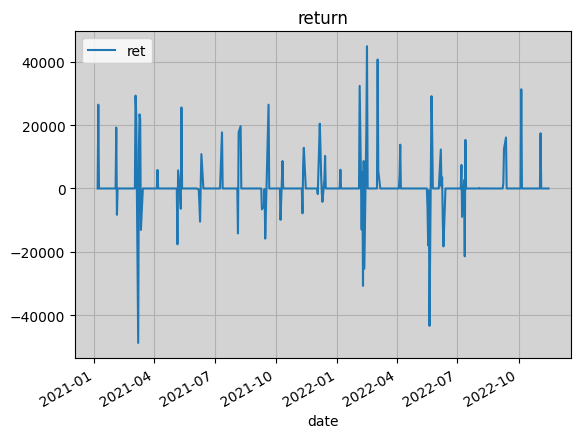

In [76]:
res2_df.plot(y='ret')
plt.title('return')
plt.gca().set_facecolor('lightgray')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

    PnL

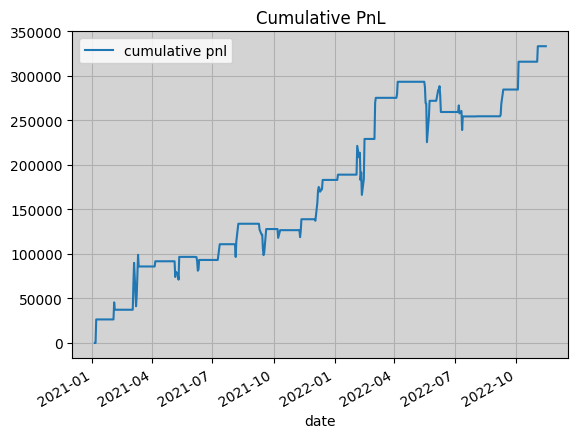

In [288]:
res2_df.plot(y='cumulative pnl')
plt.title('Cumulative PnL')
plt.gca().set_facecolor('lightgray')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

    Spread Trading Plot

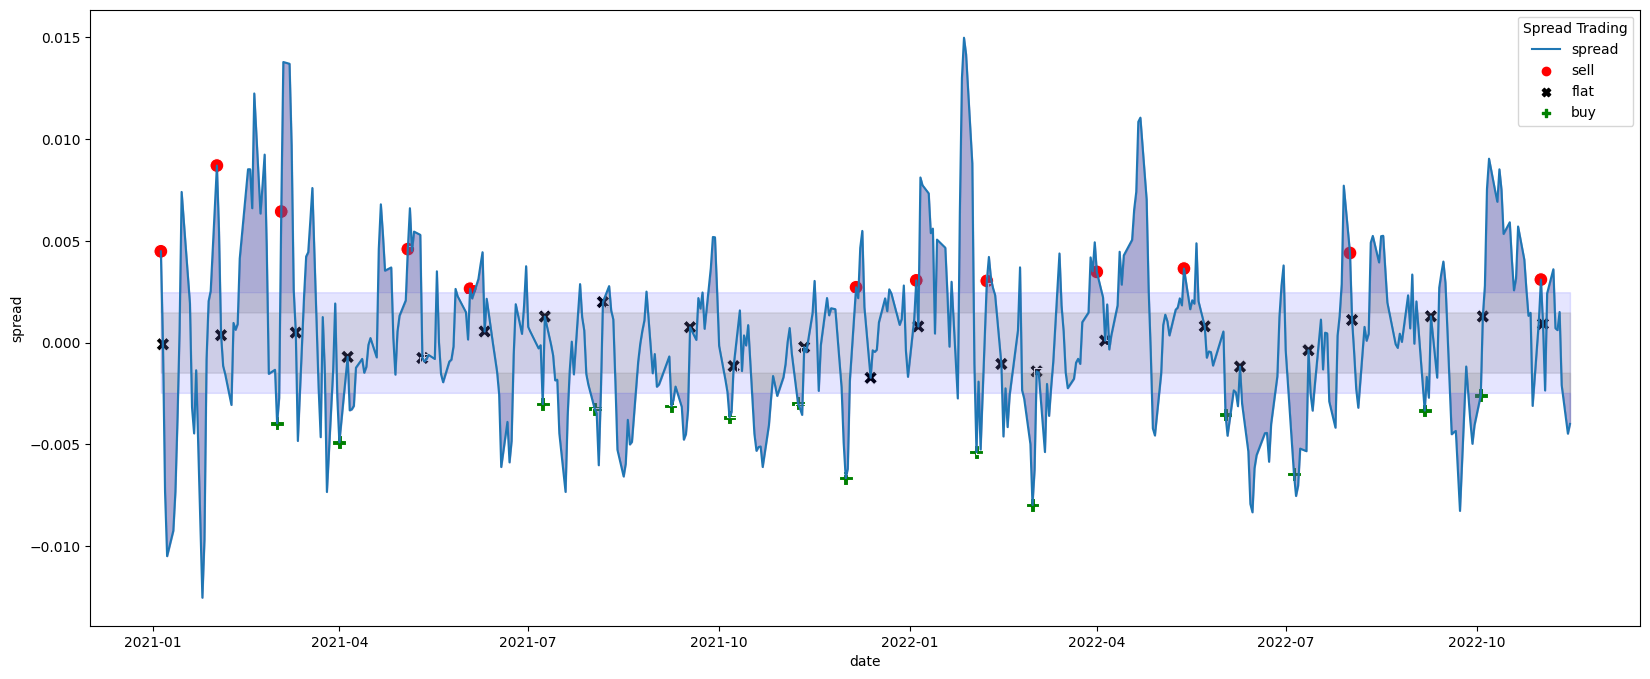

In [331]:
plt.figure(figsize=(20, 8))
sns.lineplot(x='date', y='spread', data=res2_df, label='spread')
sns.scatterplot(x='date', y='spread', hue='trade', data=res2_df, marker='o', s=100, style='trade',palette={'buy':'green','sell':'red', 'flat': 'black'})
plt.fill_between(res2_df.index, res2_df['spread'], 0.00247, color='blue', alpha=0.1)
plt.fill_between(res2_df.index, res2_df['spread'], 0.00148, color='gray', alpha=0.2)
plt.fill_between(res2_df.index, res2_df['spread'], -0.00148, color='gray', alpha=0.2)
plt.fill_between(res2_df.index, res2_df['spread'], -0.00247, color='blue', alpha=0.1)
plt.legend(title='Spread Trading')
plt.show()

### Correlation with Fama-french Factors

    a. ETF RYU - XLU Spread vs Fama French 3 Factors 

In [82]:
spread_mkt = pearsonr(data['spread']['2021-01':], fama_french['Mkt-RF']['2021-01':])
spread_smb = pearsonr(data['spread']['2021-01':], fama_french['SMB']['2021-01':])
spread_hml = pearsonr(data['spread']['2021-01':], fama_french['HML']['2021-01':])

print(f"Spread vs Mkt-RF: Correlation={spread_mkt[0]:.3f}, p-value={spread_mkt[1]:.3f}")
print(f"Spread vs SMB: Correlation={spread_smb[0]:.3f}, p-value={spread_smb[1]:.3f}")
print(f"Spread vs HML: Correlation={spread_hml[0]:.3f}, p-value={spread_hml[1]:.3f}")

Spread vs Mkt-RF: Correlation=-0.057, p-value=0.214
Spread vs SMB: Correlation=0.002, p-value=0.965
Spread vs HML: Correlation=0.319, p-value=0.000


Comments: The correlation between the spread and market risk-free rate is not significant, as indicated by the low correlation coefficient (-0.057) and high p-value (0.214). The correlation between the spread and the small minus big factor (SMB) is also not significant, as indicated by the low correlation coefficient (0.002) and high p-value (0.965). However, there is a significant positive correlation between the spread and the high minus low factor (HML), as indicated by the high correlation coefficient (0.319) and low p-value (0.000).

The HML (high minus low) factor represents the performance difference between companies with high book-to-market ratios and those with low book-to-market ratios. High book-to-market ratio companies are typically considered value companies, while low book-to-market ratio companies are typically considered growth companies.

It's possible that the spread between the two ETFs is positively correlated with the HML factor because the value companies within the utility sector may be performing better than the growth companies within the sector. This would cause the spread between the ETFs to widen, as the value-oriented ETF (RYU) would outperform the growth-oriented ETF (XLU). This relationship can be verified by looking at the underlying holdings of the ETFs and comparing their book-to-market ratio.

    a. Best Case ret vs Fama French 3 Factors 

In [87]:
spread_mkt = pearsonr(res2_df['ret']['2021-02':'2022-10'], fama_french['Mkt-RF']['2021-02':'2022-10'])
spread_smb = pearsonr(res2_df['ret']['2021-02':'2022-10'], fama_french['SMB']['2021-02':'2022-10'])
spread_hml = pearsonr(res2_df['ret']['2021-02':'2022-10'], fama_french['HML']['2021-02':'2022-10'])

print(f"Return vs Mkt-RF: Correlation={spread_mkt[0]:.3f}, p-value={spread_mkt[1]:.3f}")
print(f"Return vs SMB: Correlation={spread_smb[0]:.3f}, p-value={spread_smb[1]:.3f}")
print(f"Return vs HML: Correlation={spread_hml[0]:.3f}, p-value={spread_hml[1]:.3f}")

Return vs Mkt-RF: Correlation=0.071, p-value=0.134
Return vs SMB: Correlation=-0.029, p-value=0.539
Return vs HML: Correlation=-0.041, p-value=0.389


Comments: The correlation between return and market risk-free rate is not significant, as indicated by the low correlation coefficient (0.071) and high p-value (0.134). The correlation between return and the small minus big factor (SMB) is also not significant, as indicated by the low correlation coefficient (-0.029) and high p-value (0.539). The correlation between return and the high minus low factor (HML) is also not significant, as indicated by the low correlation coefficient (-0.041) and high p-value (0.389).

In general, a low correlation coefficient and a high p-value suggest that there is little to no relationship between the two variables. It means that there is no clear linear relationship between the returns of the investment and the factors (market risk-free rate, SMB and HML) being analyzed.

### Colusion:

Through this exercise I observe below advantages of pairs trading strategy:

Risk diversification: Pairs spread trading allows traders to diversify their risk by simultaneously buying and selling two related securities. This can help to reduce the overall risk of the trade.

Limited downside risk: By shorting one security and going long on another, traders can limit their downside risk. If the spread between the two securities widens, the long position will increase in value, offsetting any losses on the short position. Throughout the whole trading exercise, my stop loss function never got triggered as the strategy is fairly safe and compared to the huge traded cash amount, the loss is almost negligible.


Profit potential in both rising and falling markets: Pairs spread trading can be profitable in both rising and falling markets. In a rising market, the long position will increase in value while the short position will decrease in value, resulting in a profit. In a falling market, the short position will increase in value while the long position will decrease in value, also resulting in a profit.

Reduced volatility: Pairs spread trading can also help to reduce volatility. By buying and selling two related securities at the same time, traders can effectively "hedge" their positions, reducing the impact of market fluctuations.

Easy to execute and monitor: Pairs spread trading is relatively easy to execute and monitor as it involves trading only two securities. This makes it an accessible strategy for traders of all experience levels.